##### This notebook shows how to load one's own custom data in to the Data Lake and Fault data into Maximo

In [ ]:
'''
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
'''

In [ ]:
### adds notebook to execution json for testing automation
### fast_execution.json will be used to pass the asset_group_id and device_type to be used in the PMI version notebooks for POC purpose.
notebook_name = "FastStartLoader-Predict"
notebook_precursors = []
import json
from project_lib import Project
project = Project.access()
try:
    store = json.load(project.get_file("fast_execution.json"))
except:
    store = {}
    print("No execution json found, initialising with current notebook information")
store[notebook_name] = {"precursors":notebook_precursors, "outputs":{}}
store_json = json.dumps(store)
project.save_data("fast_execution.json", store_json, overwrite=True)
print("Notebook added to json")

f = open('/project_data/data_asset/fast_execution.json',)
data = json.load(f)
print(data)

In [ ]:
!hostname

'''
Licensed Materials - Property of IBM
IBM Maximo APM - Predictive Maintenance Insights On-Premises
IBM Maximo APM - Predictive Maintenance Insights SaaS 
IBM Maximo Application Suite
© Copyright IBM Corp. 2019,2020,2021 All Rights Reserved.
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.
'''

##### This notebook performs some essential functions needed for a PoC to work. This configures the Maxim-Predict and underneath platform

+ Part I - Load the Data
  + 1.1 Introduction
  + 1.2 Install pmlib and initialize system
  + 1.3 Download training and testing data
  + 1.4 Load data and covert to dataframes
  + 1.5 Construct 4 dataframes each for training and testing
  + 1.6 Delete existing data from Maximo-Predictdata lake
  + 1.7 Insert data into data lake


## Part I - Load the Data

### 1.1 Introduction


The notebooks use a sample dataset to show how data can be ingested, and loaded into the backend systems in Maximo-Predict before a data scientist can proceed to train the models.

This notebook should be run to setup the data in Maximo-Predict before scoring. The following flow chart illustrates the sequence of steps, following which this demo can be adapted for any dataset.

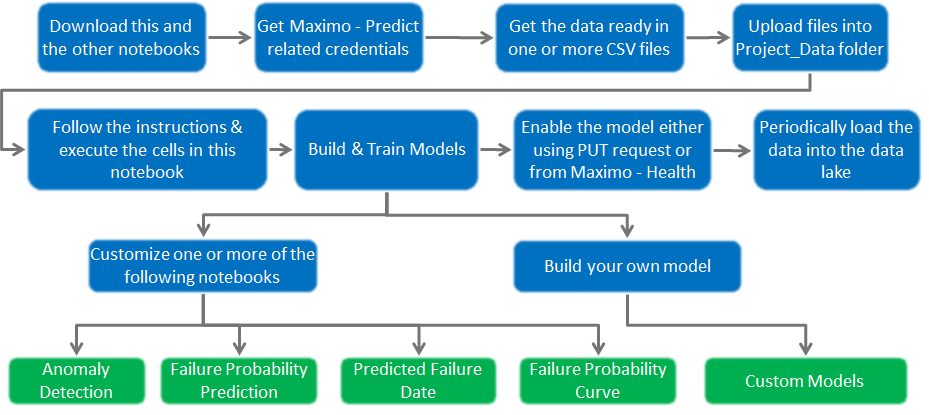

There are 2 notebooks provided including this one. This notebook creates the objects in Maximo-Predict, and loads the essential data into the systems.

This notebook performs a series of operations involving Maximo-Predict as outlined in the following flowchart. Note that it is preferable to delete the objects in the system before recreating them for the demo purposes. The following diagram shows the sequences of delete operations and create operations performed in this notebook. Not following this recommendation could leave corrupt entries behind  causing errors and poor results. 

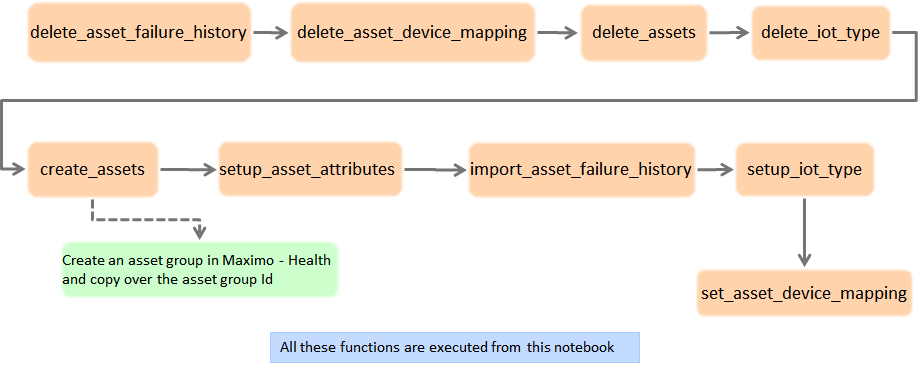

A brief explanation of these operations is as follows

+ **asset_device_mapping**: In reality, assets and their observation (from sensor readings) are usually processed separately. In most cases, asset and sensor data come from and managed by different systems. Maximo-Predict supports getting asset data stored and managed by Maximo, and sensor data from Watson IoT Platform. Assets and sensors are different entities and in order to use both data together, we need to link individual assets and sensors. This is what asset-device mapping is for. Essentially, it indicates for a sensor reading comes in which asset the reading belongs to. An asset can be associated with one or more sensors. On the other hand, a sensor can also be linked to multiple assets, though not common.

+ **Site**: In Maximo, to uniquely identify an asset, you need a site and an asset ID. There are many considerations in planning Maximo organization and site structures, but for our purpose, using assets in Maximo-Predict, we need both site and asset ID in order to identify an asset. If you don't have any site created yet, it's fine to start with site 'BEDFORD' which comes with the sample data set in Maximo.

#### Prerequisites for building the demo

+ Obtain access to Maximo-Predict
+ Get the datasets ready as CSV files (see below)
+ Load all the notebooks into your Watson Studio project

#### Maximo-Predict requires following csv files (dataframes). If your csv files are not in the same format you will need to convert them. We will show you an example in this notebook. 

As you can see in the following formats, there are things that come from your dataset. For example, things like `asset_id` (12 char or less), which is the id of the asset being analyzed, monitored, and studied. However things like `site`, and `devicetype` are the ones you configure in Maximo and IoT platform before embarking on this exercise. 

Except where stated explicitly, the names of the columns are up to the user's choice. It is a matter of preference whether you call it `asset_id` or `equipment_id`. However if your dataset involves a column name different from the one shown here in the example, you need to change the pandas function accordingly in one or more cells below. If you would rather avoid that exercise, then prepare your data using the following structure including the column names to the extent possible. 

Likewise the variable names are also changeable. Instead of calling your IoT object `devicetype`, you can choose to call it `iot_device_type`, so that you can use the word `devicetype` (or `device_type`) for something in your dataset. But if you choose to change any of the variables declared here, then it is important you modify the place(s) where the variables are used.

It should be noted that the column names could be case sensitive in various systems, and certainly so in Pandas. Therefore it is safer to use a consistent case across your variables and other names.

+ Combined Asset and Asset Attribute csv file (dataframe) format -

| asset_id | installation_timestamp | site |
| ----- | ----- | ---- |  
| LOBA20 | 2017-01-19 05:46:29 | BEDFORD|  

+ Asset failure history csv file (dataframe) format -

| asset_id | timestamp | site | deviceid |
|------------| ------- | ------------ | ------ |
| LOBA20 |  2017-01-19 23:29:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-07 00:18:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-08 09:20:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-09 09:06:00 | BEDFORD | LOBSensor20191004_1 |
| LOBA20 |  2017-02-17 13:41:00 | BEDFORD | LOBSensor20191004_1 |

+ IOT sensor csv file (dataframe) format -


| asset_id | timestamp | var1 | var2| var3 | ...... | var_n| deviceid | devicetype |
|------------| ------- | ------------ | ------ | -------|-------|--------|------------|----------------|
| LOBA20 |  2017-01-19 23:29:00 | 34.35 | 65.86 |467.39| ....| 464.73|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-21 17:38:48 | 47.48 | 38.59 | 483.49| ....|463.59|LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  2017-01-19 21:59:37 | 36.67 | 37.76 | 294.65| ....|120.57|LOBSensor20191004_1 | LOBSensor20191004 |


+ Asset-Device mapping csv file (dataframe) format - 

| asset_id | site   | deviceid | devicetype|
|------------| ------- | ------------ | ------ |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |
| LOBA20 |  BEDFORD | LOBSensor20191004_1 | LOBSensor20191004 |

### 1.2 Install Maximo-Predict SDK and initialize system

##### [Instruction] Assign the right values for the following variables specific to the APM instance you are using for the demo

To install the SDK, you need your Maximo Maximo-Predict instance ID (APM_ID), API base URL (APM_API_BASEURL), and your API key (APM_API_KEY). The Maximo APM PMI instance ID and API base URL are configured in your cluster. For API key, request to your Maximo admin to create an user account first to generate one for you. Create one environment variable for each here.

Predict uses Predict_Envs.json to store the environment varaibles. The format of the Predict_Envs.json is the following:

{'Instruction': {'APM_ID': 'Application Administration -> System Properties -> Filter -> Search PMIId -> Current Value (eg. b95ed774)', 'APM_API_KEY': 'Application Administration -> Go To Administration -> Integration -> API Keys -> Copy key from user card (e.g. 6805t46gn3tef37pu0picpg9vcq3hsmamm1enc43), or Add API key if not exist.', 'APM_API_BASEURL': 'Application Administration -> Integration -> End Points--> Searh for predict -> click search result PREDICTAPI -> URL (e.g https://predict-api.mas-pmidev1-predict.svc, note you just need first part of the url). From MAS 8.4 we will support external url as well. The external url is constructed with this pattern during MAS-Predict installation - https://{workspaceId}.predict.{DOMAIN},  e.g. https://main.predict.test.ivt03.suite.maximo.com. It is defined at installation time. Please get it from your admin'}, 'APM_ID': 'b609395e', 'APM_API_BASEURL': 'https://ivt08rel86-predict-api.mas-ivt08rel86-predict.svc', 'APM_API_KEY': '2l68dpbqc8gikd4lgthnbqenpje7ht08maeok9sr', 'USER_PROVIDED_HEALTH_URL': '', 'USER_PROVIDED_DB_CONNECTION_STRING': '', 'USER_PROVIDED_URL': ''}


In [ ]:
import json
import os
# Opening JSON file
f = open('/project_data/data_asset/Predict_Envs.json',)
data = json.load(f)
print(data)
f.close()
os.environ['APM_ID'] = data['APM_ID']
os.environ['APM_API_BASEURL'] = data['APM_API_BASEURL']
os.environ['APM_API_KEY'] = data['APM_API_KEY']


In [ ]:
!pip uninstall -y pmlib

In [ ]:
import os

os.environ['SSL_VERIFY_APM'] = 'False'
os.environ['SSL_VERIFY_AS'] = 'False'
os.environ['TRUST_PREDICT']= os.getenv('APM_API_BASEURL')[8:]

print(os.getenv('TRUST_PREDICT'))

This notebook will generate asset_group_id for POC purpose. We use fast_execution.json to store the asset_group_id.

In [ ]:
import json
from project_lib import Project
project = Project.access()
store = json.load(project.get_file("fast_execution.json"))
store
notebook_name = "FastStartLoader-Predict"
notebook_precursors = []
store[notebook_name] = {"precursors":notebook_precursors, "outputs":{"asset_group_id": None, "device_type": None}}
store_json = json.dumps(store, indent =4)
project.save_data("fast_execution.json", store_json, overwrite=True)
print("Notebook added to json")
for precursor in notebook_precursors:
    for nb in store:
        if precursor == nb:
            #Found precursor. Check if it has output(meaning it has been run)
            if store[precursor]["outputs"] == None or store[precursor]["outputs"] == [None] or store[precursor]["outputs"] == []:
                #Precursor has not been run. Must run before notebook can be run
                raise ValueError(precursor + " must run before this notebook.")

######  Installation PM libraries

In [ ]:
!pip install --trusted-host ${TRUST_PREDICT} ${APM_API_BASEURL}/ibm/pmi/service/rest/ds/${APM_ID}/${APM_API_KEY}/lib/download?filename=pmlib

# !pip install /project_data/data_asset/pmlib.zip

In [ ]:
# Initialize the Maximo-Predict environment variables

import pmlib
from pmlib import api
from pmlib.api import _call_maximo

#from pmlib.api import init_environ
#from pmlib.util import current_directory
#from iotfunctions.db import Database
#pmlib.setup_logging()
api.init_environ()

In [ ]:
import pandas as pd
import numpy as np
import requests, zipfile

import json
import os
import time
from datetime import datetime 
from datetime import timedelta
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simple_filter = simplefilter(action='once', category=UserWarning)

In [ ]:
# default_site_id = 'DIST2'
default_site_id = 'EULARGE1'
newAssetPrefix='ST'

asset_group_label_afm  = newAssetPrefix+'_'+default_site_id+'_For_Predict_Demo'

print('asset_group_label_afm = '+asset_group_label_afm)

default_device_type = 'Pump_'+default_site_id+'_'+newAssetPrefix
device_type_afm  = default_device_type 
store[notebook_name]["outputs"]["device_type"] = default_device_type

In [ ]:
asset_installation_decommission_dates_df = pd.read_csv('/project_data/data_asset/hpu_st_asset_installation_decommission_date_afm.csv')
# asset_installation_decommission_dates_df = pd.read_csv('/project_data/data_asset/hpu_st_asset_installation_decommission_date_afm.csv')

asset_installation_decommission_dates_df['installation_date'] = pd.to_datetime(asset_installation_decommission_dates_df['installation_date'])
asset_installation_decommission_dates_df['decommission_date'] = pd.to_datetime(asset_installation_decommission_dates_df['decommission_date'])
print(asset_installation_decommission_dates_df.shape)
asset_installation_decommission_dates_df.head()

In [ ]:
sensor_data_afm_df = pd.read_csv('/project_data/data_asset/hpu_st_sensor_data_afm_vel_timeshifted_v17.csv')
# sensor_data_afm_df = pd.read_csv('/project_data/data_asset/hpu_st_sensor_data_afm_vel_timeshifted_v17.csv')

sensor_data_afm_df.head()

sensor_data_afm_df = sensor_data_afm_df.drop(columns =['deviceid','devicetype'],axis=1)
sensor_data_afm_df['devicetid']=sensor_data_afm_df['asset_id']
sensor_data_afm_df['devicetype'] = device_type_afm

print(sensor_data_afm_df.shape)

sensor_data_afm_df.head()

In [ ]:
item='timestamp'
sensor_data_afm_df[item] = pd.to_datetime(sensor_data_afm_df[item])
sensor_data_afm_df=sensor_data_afm_df.rename(columns={'timestamp':'customtime'})

sensor_data_afm_df.head()

In [ ]:
# You will define your own device_type, site_id, asset_prefix and install_date for your training dataset
# Please mark down device_type used here. You will need it in next notebook
device_ids_afm = sensor_data_afm_df['asset_id'].unique()
# device_ids_afm = ['ST_1393137','ST_1393138','ST_1400501','ST_1400503','ST_1400504']
print(device_ids_afm)



In [ ]:
failure_data_afm_df = pd.read_csv('/project_data/data_asset/hpu_st_failure_data_afm_vel_timeshifted_v17.csv')
# failure_data_afm_df = pd.read_csv('/project_data/data_asset/hpu_st_failure_data_afm_vel_timeshifted_v17.csv')

failure_data_afm_df['fail_date'] = pd.to_datetime(failure_data_afm_df['fail_date'])
failure_data_afm_df['site_id']=default_site_id

item='fail_date'
failure_data_afm_df[item] = pd.to_datetime(failure_data_afm_df[item])

print(failure_data_afm_df.shape)
failure_data_afm_df.head()


##### Note that this example loads the data into the underlying systems as follows:
+ As for Measurement data, the testing segment is loaded in the data lake as example, but you can choose to load both training and testing segments qualified by different device_type and asset_prefixes . The pattern illustrated here is assuming the training is done using CSV files, and the scoring happens on the data in the data lake & Maximo on an ongoing basis. 
+ The training part of the measurement data is set aside for the training to be done in a separate notebook provided in this package (refer to the notebook titled `DTE_Failure_Probability_Estimation_Training`). 
+ As for the failure data, the entire data is loaded. 

In [ ]:
#all_assets = list(sensor_data_oem_df['asset_id'].unique())
#all_assets.extend(list(sensor_data_afm_df['asset_id'].unique()))

asset_all_df = asset_installation_decommission_dates_df.copy()
asset_all_df.rename({'asset_id':'asset'}, axis = 1, inplace = True)
asset_all_df['devicetype'] = asset_all_df['asset'].map(lambda x: device_type_afm if x in list(sensor_data_afm_df['asset_id'].unique()) else device_type_afm)
asset_all_df['deviceid'] = asset_all_df['asset']
asset_all_df['site'] = default_site_id
asset_all_df.head(10)

#### 1.5.3 Construct asset device mapping

In [ ]:
asset_device_mapping_df = asset_all_df.drop(['installation_date','decommission_date'], axis = 1)
asset_device_mapping_df.head(10)

In [ ]:
from pmlib.api import _call_maximo

# clean up filter and assetgroup
def get_asset_group_href(grouplabel):
    if grouplabel is None:
        raise ValueError('the given argument grouplabel is None')
    resp = _call_maximo(url_path='/os/MXAPIEXPGROUP?lean=1&addid=1&oslc.where=grouplabel=%22'+grouplabel+'%22&oslc.select=*', method='get')
    if resp is not None:
        data = resp.json()
        print(data)
        if len(data['member']) != 0:
            return (data['member'][0]['href'])
    return 0
def delete_asset_group(grouplabel):
    if grouplabel is None:
        raise ValueError('the given argument grouplabel is None')
    href = get_asset_group_href(grouplabel)
    if href != 0 :
        url_path=href.split("/api")[1]
        print(url_path)
        resp = _call_maximo(url_path=url_path, method='delete')
        print(resp)

### 1.6 Delete existing data

**In the next few cells the objects in Maximo-Predict data lake are going to be deleted. This is to make sure you can recreate this flow as many times as necessary (or if something goes wrong in the first attempt).**

In [ ]:
# delete failure history for training. Note that we delete all the events here including both training and testing segments. 
# This is being done in order to minimize calls across the wire to the underlying system (Maximo). This is fine as long as the dataset is small in size. For large datasets this will unnecessarily
# increase the memory footprint. In that case you may be better off not combining things into one dataset

resp = pmlib.delete_asset_failure_history(failure_data_afm_df, siteid_column='site_id', assetid_column='asset_id')
print(resp)

In [ ]:
asset_device_mapping_df

In [ ]:
# delete asset_device mapping for training
pmlib.delete_asset_device_mappings(df=asset_device_mapping_df)

In [ ]:
# delete training asset
# resp = pmlib.delete_assets(asset_all_df, siteid_column='site', assetid_column='asset')
# print(resp)

In [ ]:
device_type_afm

In [ ]:
# delete sensor data from data lake for training
#pmlib.delete_iot_type(name=device_type_oem)
#time.sleep(300) # wait 5 minute for AS to finish the job. 
pmlib.delete_iot_type(name=device_type_afm)
time.sleep(300) # wait 5 minute for AS to finish the job. 

**Note:** Need to wait for 5 minutes before insert

In [ ]:
asset_group_id = pmlib.api.get_maximo_asset_group_id(asset_group_label_afm)
print(asset_group_id)
if asset_group_id is not None:
    url = os.environ.get('APM_API_BASEURL', None) + '/ibm/pmi/service/rest/assetgroup/' + asset_group_id + '?instanceId=' +os.environ.get('APM_ID', None)
    header={
        'apmapitoken':os.environ.get('APM_API_KEY', None)
    }
    response = requests.delete(url, headers=header,verify=False)
    print(response)

delete_asset_group(asset_group_label_afm)

### 1.7 Insert data

**Now we will start creating the asset objects sensor objects**

Normally, we would manage assets from Maximo. But Maximo-Predict SDK also supports bulk loading assets into Maximo directly from within notebook. This could be useful to load some sample non-existent asset data from CSV files.

In [ ]:
asset_all_df

In [ ]:
from pandas import Timedelta
# step 1 - calculate timeshift
timestamp_col_name='customtime'
timeshift = (datetime.now() - sensor_data_afm_df[timestamp_col_name].max() - timedelta(days=2)).days
print(f'Shifting {timeshift} days forward')

In [ ]:
item='fail_date'
failure_data_afm_df[item] = pd.to_datetime(failure_data_afm_df[item])
failure_data_afm_df[item] = failure_data_afm_df[item] + timedelta(days=timeshift)
sensor_data_afm_df[timestamp_col_name] = sensor_data_afm_df[timestamp_col_name] + timedelta(days=timeshift)
print("Sensor Date Min: ") 
print(sensor_data_afm_df[timestamp_col_name].min())
print("Sensor Date Max: ") 
print(sensor_data_afm_df[timestamp_col_name].max())
failure_data_afm_df.head(5)

In [ ]:
# Invoke the PMLIB API to create the asset  in Maximo for training
# resp = pmlib.create_assets(asset_all_df, assetid_column='asset', siteid_column='site')

In [ ]:
# 2.1 create asset attributes for testing. i.e. installdate
# resp = pmlib.setup_asset_attributes(asset_all_df, assetid_column='asset', siteid_column='site', attribute_columns=['installation_date'], parse_dates=['installation_date'])
# print(resp)

In [ ]:
# Check whether the failure code is in current organization, otherwise, create one.
# Get orgid
orgid=''
resp = api._call_maximo('/os/mxapiorganization?lean=1&oslc.select=orgid&oslc.where=site.siteid="'+ default_site_id +'"', method='get')
if resp.status_code==200 and len(resp.json()['member']) != 0:
    orgid=resp.json()['member'][0]['orgid']
    # print(orgid)

# Check whether failure code for PUMP exists.
resp = api._call_maximo('/os/MHFAILURELIST?lean=1&oslc.select=*&oslc.where=orgid="'+ orgid +'"', method='get')
if resp.status_code==200 and 'member' in resp.json() and len(resp.json()['member']) == 0:
    failurelist=10000
    failurelistchild=10001
    headers={}
    headers['X-method-override']="BULK"
    headers['patchtype']="merge"
    payload = [
            {
                "failurecode": [
                    {
                        "failurecode": "PUMPS",
                        "description": "Pump Failures",
                        "_action":"AddChange"
                    }
                ],
                "type": "PROBLEM",
                "orgid": orgid,
                "type_description": "Problem",
                "failurelist": failurelist,
                "_action":"AddChange"
            },
            {
                "parent": failurelist,
                "flcdescription": "Pump Failures",
                "failurecode": [
                    {
                        "failurecode": "STOPPED",
                        "description": "STOPPED Failures",
                        "_action":"AddChange"
                    }
                ],
                "type": "PROBLEM",
                "orgid": orgid,
                "type_description": "Problem",
                "failurelist": failurelistchild,
                "_action":"AddChange"
            }
        ]
    resp = api._call_maximo('/os/MHFAILURELIST?lean=1', method='post',json=payload,headers=headers)
    print(resp.json())
    resp = api._call_maximo('/os/MHFAILURELIST?lean=1&oslc.select=*&oslc.where=orgid="'+ orgid +'"', method='get')
    if resp.status_code==200 and 'member' in resp.json() and len(resp.json()['member']) == 0:
        exit(1)

In [ ]:
# 3. create failure history for training, 
# default_failurecode is the CLASS  in the MAXIMO MANAGE
#default_problemcode is the PROBLEMCODE is in the MAXIMO MANAGE
# the Precondition is that default_failurecode and default_problemcode have been set up in MAXIMO MANAGE
resp = pmlib.import_asset_failure_history(failure_data_afm_df, assetid_column='asset_id', siteid_column='site_id', faildate_column='fail_date', default_failurecode='PUMPS', default_problemcode='STOPPED', wonum_prefix='apm')
print(resp)



**[Instruction] Create Asset Group **

The unit of analysis is asset group. An asset group is a set of assets with similar characteristics, to the intended models, which are used to train models applicable to all assets in the group.

To create an asset group you can call following APIs. Or, go to Maximo-Predict -> Predict Group. 

Make sure to assign the value of the asset group Id in the following cells

In [ ]:

#Create filter and asset group
def create_filter(assetFilter,assetNum):
    querypayload={
        "ispublic":True,
        "clausename":assetFilter
    }
    resp = _call_maximo(url_path='/os/mxapiasset?action=system%3Asavethisquery&oslc.where=siteid=%22'+default_site_id+'%22%20and%20assetnum=%22'+assetNum+'%25%22&lean=1', method='post',json=querypayload)

def create_asset_group(assetGroupLabel,assetFilter):
    group_payload={
        "usewith":"ASSET",
        "intobjectname":"MXAPIASSET",
        "egtype":"FILTER",
        "clausename":assetFilter,
        "usedby":"PMI",
        "grouplabel":assetGroupLabel
    }
    resp = _call_maximo(url_path='/os/MXAPIEXPGROUP?lean=1', method='post',json=group_payload)


In [ ]:
# Create Maximo query and Asset Group
create_filter(asset_group_label_afm,newAssetPrefix)
create_asset_group(asset_group_label_afm,asset_group_label_afm)

In [ ]:
asset_group_afm_id=api.get_maximo_asset_group_id(asset_group_label_afm)
print(asset_group_afm_id) # Please mark down this asset_group_id. It will be used in next notebook.
store[notebook_name]["outputs"]["asset_group_id"] = asset_group_afm_id

In [ ]:
asset_group_id=asset_group_afm_id
print(asset_group_id)

**Setup IOT Devices** 

Maximo-Predict currently supports Watson IOT Platform (WIOTP) as the data source for devices/sensors. In order to allow devices to send events to WIOTP, we have to register devices to WIOTP and setup up properly so the device events go into the data lake.

You can do it from UI, as instructed in IBM Maximo APM - Predictive Maintenance Insights Knowledge Center: Creating device types, Creating physical and logical interfaces, Configuring the integration with IBM Maximo APM - Asset Health Insights.

Or, you can also set it up directly within notebooks. In addition to setting up IOT devices, this method also supports bulk importing your device history data into data lake (from CSV files).

Let's use the just loaded dataframe df_sensor_data as an example. 

In [ ]:
sensor_data_afm_df.columns = ['customtime','asset_id','VELOCITYX','VELOCITYY','VELOCITYZ','MOTORTEMP','WINDINGTEMP','CURRENT','PRESSURE','LOAD','deviceid','devicetype']
sensor_data_afm_df.head()
sensor_data_afm_df.shape

In [ ]:
# Loading the training data. Note that this training data is used from a CSV file in a separate notebook  
t = pmlib.setup_iot_type(
    name=device_type_afm, 
    df=sensor_data_afm_df, 
    columns=['VELOCITYX','VELOCITYY','VELOCITYZ','MOTORTEMP','WINDINGTEMP','CURRENT','PRESSURE','LOAD'],
    deviceid_column='deviceid',
    timestamp_column='customtime', 
    timestamp_in_payload=True,
    #write='deletefirst',
    write='dropfirst',
    use_wiotp=True, # may create extra rows
    import_only= False) # True or False depends on whether your device type is already there in the system or not.


In [ ]:
asset_device_mapping_df

In [ ]:
# 6.1 asset_device mapping for training
pmlib.set_asset_device_mappings(df=asset_device_mapping_df, delete_df_asset_first=True, drop_table_first=False)

In [ ]:
store_json = json.dumps(store, indent =4)
project.save_data("fast_execution.json", store_json, overwrite=True)

In [ ]:
# fast_execution.json will have the asset_group_id and device_type that will be used in the following PMI version notebook for POC purpose.
import json
import os
# Opening JSON file
f = open('/project_data/data_asset/fast_execution.json',)
data = json.load(f)
print(data)
f.close()

In [ ]:
!cat /project_data/data_asset/fast_execution.json

### Scoring example

In [ ]:
raise Exception("Stop")

In [ ]:
default_device_type

In [ ]:
sensor_data_afm_df

In [ ]:
from datetime import datetime
import dateutil.relativedelta
# datetime object containing current date and time

now = datetime.now() 
dt_string = now.strftime("%Y-%m-%d")
print("date and time =", dt_string)


now = datetime.now()
start = now + dateutil.relativedelta.relativedelta(months=-1)
nextM = now + dateutil.relativedelta.relativedelta(months=+1)

print(start.strftime("%Y-%m-%d"))

print(nextM.strftime("%Y-%m-%d"))

delta = now - start
print(delta.days)

days=delta.days+1


In [ ]:
# make up some scoring data between 1st Jan 2021 till 01/28/2021
for pump_id in asset_installation_decommission_dates_df['asset_id'].unique() :
    velocity_x = np.random.permutation(sensor_data_afm_df['velocityx'].values)[0:days]
    velocity_y = np.random.permutation(sensor_data_afm_df['velocityy'].values)[0:days]
    velocity_z = np.random.permutation(sensor_data_afm_df['velocityz'].values)[0:days]

    motor_temp = np.random.permutation(sensor_data_afm_df['motortemp'].values)[0:days]
    winding_temp = np.random.permutation(sensor_data_afm_df['windingtemp'].values)[0:days]
    current = np.random.permutation(sensor_data_afm_df['current'].values)[0:days]

    pressure = np.random.permutation(sensor_data_afm_df['pressure'].values)[0:days]
    load = np.random.permutation(sensor_data_afm_df['load'].values)[0:days]


    df_scoring_data = pd.DataFrame({'VELOCITYX': velocity_x, 'VELOCITYY':velocity_y, 'VELOCITYZ':velocity_z, 'MOTORTEMP':motor_temp, 'WINDINGTEMP':winding_temp, 'CURRENT':current,
                                                                 'PRESSURE':pressure, 'LOAD':load},columns=['VELOCITYX','VELOCITYY','VELOCITYZ','MOTORTEMP','WINDINGTEMP','CURRENT','PRESSURE','LOAD'])
    df_scoring_data['timestamp'] = pd.date_range(start,now, freq = 'D')

    df_scoring_data.rename({'timestamp':'customtime'},axis=1,inplace=True)
    df_scoring_data['devicetype'] = default_device_type
    df_scoring_data['deviceid'] = pump_id
    print(df_scoring_data.shape)
    df_scoring_data.head()
    
    t = pmlib.setup_iot_type(
    name=default_device_type, 
    df=df_scoring_data, 
    columns=['VELOCITYX','VELOCITYY','VELOCITYZ','MOTORTEMP','WINDINGTEMP','CURRENT','PRESSURE','LOAD'],
    deviceid_column='deviceid',
    timestamp_column='customtime', 
    timestamp_in_payload=True,
    write='append',
    use_wiotp=True,
    import_only= True)

In [ ]:
# raise Exception("exit")

In [ ]:
#For update assets for asset detail page Next PM, and MRR charts

In [ ]:
import random

from datetime import datetime
import dateutil.relativedelta
# datetime object containing current date and time
now = datetime.now()

In [ ]:
from pmlib.api import _call_maximo

headers={}
headers['X-method-override']="BULK"
headers['patchtype']="merge"
def create_pm(nextPMDate,assetnum):
    pm_payload=[{
        "nextdate": nextPMDate,
        "assetnum": assetnum,
        "siteid":default_site_id,
        "description": assetnum+" "+ default_site_id,
        "wostatus": "WSCH",
        "parentchgsstatus": True,
        "frequency": 0,
        "usefrequency": True,
        "pluscduedate": False,
        "pmassetwogen": False,
        "status_description": "Active",
        "ltdpmcounter": 0,
        "repairlocflag": False,
        "schedearly": False,
        "reforecast": False,
        "jpseqinuse": False,
        "wostatus_description": "Waiting to be scheduled",
        "sunday": True,
        "pmcounter": 0,
        "leadtime": 0,
        "reqasstdwntime": False,
        "targstarttime": "1970-01-01T00:00:00+00:00",
        "status": "ACTIVE",
        "copywheninactive": False,
        "saturday": True,
        "lockforecast": False,
        "storelocsite": default_site_id,
        "alertlead": 0,
        "friday": True,
        "wednesday": True,
        "erlstwogendate": nextPMDate,
        "monday": True,
        "thursday": True,
        "interruptible": False,
        "overridemasterupd": False,
        "inclforecast": True,
        "downtime": False,
        "statusiface": False,
        "tuesday": True,
        "pmactmeter": False,
        "usetargetdate": True,
        "adjnextdue": False,
        "frequnit": "DAYS",
        "haschildren": False,       
        "_action":"AddChange"
        
    }]
    resp = _call_maximo(url_path='/os/MHPM?lean=1', method='post',json=pm_payload,headers=headers)
    print(resp)

In [ ]:
# for asset in asset_installation_decommission_dates_df['asset_id'].unique() :
    


In [ ]:
#set mxe.workorder.rollupMaintenanceCosts property to 1 so it will auto calculate and update totalcost. Without this, you have to always run a report, which is not good.
body={
    'serverName': 'COMMON',
    'propName':'mxe.workorder.rollupMaintenanceCosts',
    'propValue': '1'
}
    
resp = _call_maximo(url_path='/service/system?lean=1&action=wsmethod:setProperty', method='post',json=body)
print(resp)

In [ ]:
#Update asset cos

In [ ]:
from pmlib.api import _call_maximo

headers={}
headers['X-method-override']="BULK"
headers['patchtype']="merge"

def update_asset_PURCHASEPRICE_REPLACECOST(assetnum):
    pm_payload=[{        
        "assetnum": assetnum,
        "siteid":default_site_id,
        "replacecost":random.choice([80000,90000,95000]),
        "purchaseprice":random.choice([100000,110000,120000]),
        "_action":"AddChange"        
    }]
    resp = _call_maximo(url_path='/os/MHASSET?lean=1', method='post',json=pm_payload,headers=headers)
    print(resp)
    
def create_wo(assetnum):
    payload=[{        
        "assetnum": assetnum,
        "siteid":default_site_id,
        "wonum":"WO001_"+assetnum,
        "wpmaterial":[
            {
                "unitcost": random.choice([10,11,12,13,14,15,16,17,18,19,20,50]),
                "itemqty": random.choice([100,110,120,130,140,150,160,170,180,190,200,500]),
                "linetype": "MATERIAL",
                "linetype_description": "Material",
                "unitcosthaschanged": True,
                "description": "Material",
                "_action":"AddChange"
            }
        ],
        "_action":"AddChange"        
    }]
    resp = _call_maximo(url_path='/os/MXAPIWODETAIL?lean=1', method='post',json=payload,headers=headers)
    print(resp)
    
def approve_wo(assetnum):
    payload=[{        
        "siteid":default_site_id,
        "wonum":"WO001_"+assetnum,
        "status": "APPR",
        "_action":"AddChange"        
    }]
    resp = _call_maximo(url_path='/os/MXAPIWODETAIL?lean=1', method='post',json=payload,headers=headers)
    print(resp)
    
def complete_wo(assetnum):
    payload=[{        
        "siteid":default_site_id,
        "wonum":"WO001_"+assetnum,
        "status": "COMP",
        "matusetrans": [
            {
                "issuetype": "ISSUE",
                "linetype": "MATERIAL",
                "description": "MATERIAL COST",
                "positivequantity": random.choice([100,110,120,130,140,150,160,170,180,190,200,500]),
                "unitcost": random.choice([10,11,12,13,14,15,16,17,18,19,20,50])
            }
        ],
        "_action":"AddChange"        
    }]
    resp = _call_maximo(url_path='/os/MXAPIWODETAIL?lean=1', method='post',json=payload,headers=headers)
    print(resp)
    
def close_wo(assetnum):
    payload=[{        
        "siteid":default_site_id,
        "wonum":"WO001_"+assetnum,
        "status": "CLOSE",
        "_action":"AddChange"        
    }]
    resp = _call_maximo(url_path='/os/MXAPIWODETAIL?lean=1', method='post',json=payload,headers=headers)
    print(resp)

In [ ]:
for asset in asset_installation_decommission_dates_df['asset_id'].unique() :
    nextM = now + dateutil.relativedelta.relativedelta(months=+random.choice([1,2,3,4,5,6,7,8,9]))
    nextM = nextM.strftime("%Y-%m-%d")
    nextM   
    create_pm(nextM,asset)
    
    update_asset_PURCHASEPRICE_REPLACECOST(asset)
    
    create_wo(asset)
    approve_wo(asset)
    complete_wo(asset)
    close_wo(asset)

# scoring